In [639]:
# Dependencies
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import requests
import time
import json
import gmaps
import gmaps.datasets
import gmaps.geojson_geometries
import zipcodes
import censusgeocode as cg

import geopandas
from census import Census
from us import states
import us

# census key
from api_keys import (ckey, gkey)

# Census API Key
c = Census(ckey, year=2010)

### Create dataframes from files

In [101]:
# Read and format zipcode incident data into dataframe
incidentsByZip_data = pd.read_csv("ZipcodeData.csv", dtype={'Zipcode': 'str'})
incidentsByZip_df = pd.DataFrame(incidentsByZip_data)
incidentsByZip_df = incidentsByZip_df.rename(columns = {"City Or County":"City"})
incidentsByZip_df["Zipcode"] = [int(x) for x in incidentsByZip_df["Zipcode"]]

# Preview and inspect data to clean up for use
incidentsByZip_df.head(16)

,Unnamed: 0,Incident Date,State,City,Address,# Killed,# Injured,Zipcode
0,0,2014-12-29,LA,New Orleans,Poydras and Bolivar,0,4,70113
1,1,2014-12-27,CA,Los Angeles,8800 block of South Figueroa Street,1,3,90003
2,2,2014-12-27,CA,Sacramento,4000 block of May Street,0,4,95838
3,3,2014-12-26,IL,East St. Louis,2500 block of Summit Avenue,1,3,62205
4,4,2014-12-24,MO,Saint Louis,18th and Pine,1,3,63103
5,5,2014-12-23,KY,Winchester,260 Oxford Drive,1,3,40391
6,7,2014-12-22,NY,Webster,191 Lake Road,4,2,14580
7,8,2014-12-22,IL,Chicago,5700 block of South Green Street,0,5,60621
8,9,2014-12-21,FL,Sarasota,4034 N Washington Blvd,2,2,34234
9,10,2014-12-21,MS,Waynesboro,Central Avenue,1,4,39367


In [102]:
# Identify data types
incidentsByZip_df.dtypes

Unnamed: 0        int64
Incident Date    object
State            object
City             object
Address          object
# Killed          int64
# Injured         int64
Zipcode           int64
dtype: object

In [103]:
# Read density by zipcode data and create dataframe
density_data = pd.read_csv("Info/Zipcode-ZCTA-Population-Density-And-Area-Unsorted.csv")
density = pd.DataFrame(density_data)

# Read metropolitan cities Census data and create dataframe
metro_data = pd.read_csv("Info/Metros.csv", encoding = "ISO-8859-1")
metros = pd.DataFrame(metro_data)

# Read rural cities Census data and create dataframe
rural_data = pd.read_csv("Info/DMERuralZIP.csv")
rurals = pd.DataFrame(rural_data)

In [ ]:
# # Isolate zipcode and density/sq mi columns 
# density = density[["Zip/ZCTA", "Density Per Sq Mile"]]

# # Loop through dataframe to create a type label based on the density number
# for n in range(0, len(density["Zip/ZCTA"])):
#     if density["Density Per Sq Mile"][n] < 1000:
#         density.loc[n, "Type"] = "Rural"
#     elif 3000> density["Density Per Sq Mile"][n] > 1000:
#         if population > 50000:
#             density.loc[n, "Type"] = "Urban"
#         else:
#             density.loc[n, "Type"] = "Suburban"
#     else:
#         density.loc[n, "Type"] = "Urban"

# # Rename columns and preview to verify
# density = density.rename(columns={"Zip/ZCTA":"Zipcode","Density Per Sq Mile":"Density"})
# density.head()

In [104]:
# Isolate zipcode and density/sq mi columns 
density = density[["Zip/ZCTA", "Density Per Sq Mile"]]

# Loop through dataframe to create a type label based on the density number
for r in range(0, len(density["Zip/ZCTA"])):
    if density["Density Per Sq Mile"][r] < 1000:
        density.loc[r, "Type"] = "Rural"
    elif 1000 <= density["Density Per Sq Mile"][r] < 3000:
        density.loc[r, "Type"] = "Suburban"
    else:
        density.loc[r, "Type"] = "Urban"

# Rename columns and preview to verify
density = density.rename(columns={"Zip/ZCTA":"Zipcode","Density Per Sq Mile":"Density"})
density.head()

,Zipcode,Density,Type
0,601,0.0,Rural
1,602,0.0,Rural
2,603,0.0,Rural
3,606,0.0,Rural
4,610,0.0,Rural


### Merge data into one dataframe to use for calculations

In [105]:
# Merge zipcode incident data with metropolitan data and preview to verify
urbanDensity_df = pd.merge(incidentsByZip_df, density, how='left', on="Zipcode")

# Remove extra state column and rename remaining state column
urbanDensity_df["Density"] = round(urbanDensity_df["Density"], 2)
#urbanDensity_df.isnull()

# Preview to verify
urbanDensity_df.head()

,Unnamed: 0,Incident Date,State,City,Address,# Killed,# Injured,Zipcode,Density,Type
0,0,2014-12-29,LA,New Orleans,Poydras and Bolivar,0,4,70113,6907.57,Urban
1,1,2014-12-27,CA,Los Angeles,8800 block of South Figueroa Street,1,3,90003,18661.22,Urban
2,2,2014-12-27,CA,Sacramento,4000 block of May Street,0,4,95838,4053.81,Urban
3,3,2014-12-26,IL,East St. Louis,2500 block of Summit Avenue,1,3,62205,1847.33,Suburban
4,4,2014-12-24,MO,Saint Louis,18th and Pine,1,3,63103,3195.92,Urban


In [106]:
# Drop duplicated data rows and check total amount of incidents to verify
#citiesDensity_df = citiesDensity_df.drop_duplicates(["Incident Date", "Address"])
len(urbanDensity_df)

1258

In [107]:
hospitalData = pd.read_csv("Info/Hospital_General_Information.csv")
hospital_df = pd.DataFrame(hospitalData)
hospital_df = hospital_df[["Hospital Name","Address","City","State","ZIP Code"]]
hospital_df.head()

,Hospital Name,Address,City,State,ZIP Code
0,MARSHALL MEDICAL CENTER SOUTH,2505 U S HIGHWAY 431 NORTH,BOAZ,AL,35957
1,DEKALB REGIONAL MEDICAL CENTER,200 MED CENTER DRIVE,FORT PAYNE,AL,35968
2,CRESTWOOD MEDICAL CENTER,ONE HOSPITAL DR SE,HUNTSVILLE,AL,35801
3,CHOCTAW GENERAL HOSPITAL,"401 VANITY FAIR LANE, PO BOX 618",BUTLER,AL,36904
4,YUKON KUSKOKWIM DELTA REG HOSPITAL,PO BOX 287,BETHEL,AK,99559


0

### Group by Density Types for calculations

In [108]:
# Create grouped object by Density Type
densityType_group = urbanDensity_df.groupby("Type")

#### Total incidents by density type

In [113]:
# Calculate total number of incidents per Density Type
incidents = densityType_group.count()
incidentsByType = incidents["Zipcode"]
totalOfIncidients = incidentsByType.sum()

# Create dataframe from number of incidents by density type
shootingsByCityType=pd.DataFrame(incidentsByType)

# Rename columns, find percentages of number shot overall for each type
shootingsByCityType = shootingsByCityType.rename(columns={"Zipcode":"Total Shootings"})
shootingsByCityType["Percentage"] = shootingsByCityType["Total Shootings"]/totalOfIncidients*100
shootingsByCityType

,Total Shootings,Percentage
Type,,
Rural,262,20.843278
Suburban,264,21.002387
Urban,731,58.154336


In [114]:
shootingsByCityType.index

Index(['Rural', 'Suburban', 'Urban'], dtype='object', name='Type')

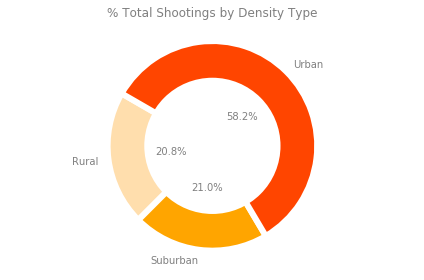

In [729]:
# Calculate Type Percents
fig, ax = plt.subplots()

ax.axis('equal')
totalShot = shootingsByCityType["Total Shootings"]

labels = shootingsByCityType.index
explode = (0, 0, 0)
colors = ['navajowhite', 'orange', 'orangered']
#plt.axis([-2, 2, -1.25, 1.25])
patches, texts, autotexts = ax.pie(totalShot, labels = labels, explode = explode, colors = colors, autopct="%1.1f%%", pctdistance = 0.4, startangle=150, wedgeprops = {'linewidth':6, 'edgecolor':'white', 'antialiased' : True})
for text in texts:
    text.set_color('grey')
for autotext in autotexts:
    autotext.set_color('grey')
    #autotext.font()
#for patch in patches:
    #patch.
center_circle = plt.Circle((0,0), 0.65, fc = 'white')
fig1 = plt.gcf()
fig1.gca().add_artist(center_circle)
plt.title("% Total Shootings by Density Type", color = 'gray')

plt.tight_layout()

plt.savefig("Images/PercentTotalShootingsDensity")
plt.show()

In [116]:
# Calculate the total number of victims(injured and killed) for each density type
victimCount = densityType_group.sum()

# Calculate and add column for percentage of vicitms killed for each density type and format
victimCount["Percentage Killed"] = victimCount["# Killed"]/(victimCount["# Killed"]+victimCount["# Injured"])*100
victimCount["Percentage Killed"] = round(victimCount["Percentage Killed"], 2)

# Calculate and add column for percentage of vicitms injured for each density type and format
victimCount["Percentage Injured"] = victimCount["# Injured"]/(victimCount["# Killed"]+victimCount["# Injured"])*100
victimCount["Percentage Injured"] = round(victimCount["Percentage Injured"], 2)

# View to verify
victimCount

,Unnamed: 0,# Killed,# Injured,Zipcode,Density,Percentage Killed,Percentage Injured
Type,,,,,,,
Rural,172113,454,975,12552626,90208.80,31.77,68.23
Suburban,176047,300,1056,13462030,532033.03,22.12,77.88
Urban,497013,690,3459,37025280,7625938.06,16.63,83.37


In [117]:
# Calculate percentages overall injured and killed overall for each desity type
totalKilled = victimCount["# Killed"].sum()
totalInjured = victimCount["# Injured"].sum()
victimCount["Percentage Overall Injured"] = victimCount["# Injured"]/totalInjured*100
victimCount["Percentage Overall Injured"] = round(victimCount["Percentage Overall Injured"], 2)
victimCount["Percentage Overall Killed"] = victimCount["# Killed"]/totalKilled*100
victimCount["Percentage Overall Killed"] = round(victimCount["Percentage Overall Killed"], 2)
victimCount

,Unnamed: 0,# Killed,# Injured,Zipcode,Density,Percentage Killed,Percentage Injured,Percentage Overall Injured,Percentage Overall Killed
Type,,,,,,,,,
Rural,172113,454,975,12552626,90208.80,31.77,68.23,17.76,31.44
Suburban,176047,300,1056,13462030,532033.03,22.12,77.88,19.23,20.78
Urban,497013,690,3459,37025280,7625938.06,16.63,83.37,63.01,47.78


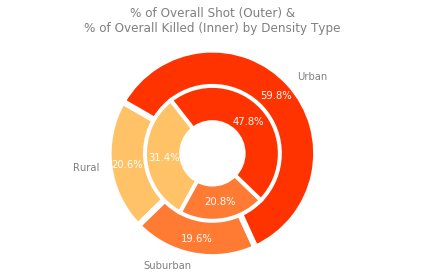

In [752]:
# Calculate Type Percents
fig, ax = plt.subplots()

ax.axis('equal')
totalShot = victimCount["# Killed"] + victimCount["# Injured"]

labels = shootingsByCityType.index
explode = (0, 0, 0)
colors = ['#ffc266', '#ff7a33', '#ff3300']

patches, texts, autotexts = ax.pie(totalShot, labels = labels, explode = explode, colors = colors, autopct="%1.1f%%", pctdistance = 0.83, startangle=150, wedgeprops = {'linewidth':6, 'edgecolor':'white', 'antialiased' : True})
for text in texts:
    text.set_color('grey')
for autotext in autotexts:
    autotext.set_color('white')

#center_circle = plt.Circle((0,0), 0.65, fc = 'white')
#fig1 = plt.gcf()
#fig1.gca().add_artist(center_circle)
#plt.title("% of Total Fares by City", color = 'gray')

plt.tight_layout()

#ax2 = plt.subplot()

totalKilled = victimCount["# Killed"]
#ax2.axis('equal')

labels = victimCount.index
explode = (0, 0, 0)
colors = ['#ffc266', '#ff7a33', '#ff3300']

patches, texts, autotexts = ax.pie(totalKilled, explode = explode, colors = colors, autopct="%1.1f%%", radius = 0.65, pctdistance = .72, startangle=128, wedgeprops = {'linewidth':4, 'edgecolor':'white', 'antialiased' : True})
for text in texts:
    text.set_color('white')
for autotext in autotexts:
    autotext.set_color('white')

center_circle = plt.Circle((0,0), 0.32, fc = 'white')
fig3 = plt.gcf()
fig3.gca().add_artist(center_circle)
plt.title("% of Overall Shot (Outer) &\n% of Overall Killed (Inner) by Density Type", color = 'gray')

plt.tight_layout()

plt.savefig("Images/PercentOverallShotKilledDensity")

plt.show()

#### Calculate amount of vicitms that fall into groupings per density type

In [153]:
# Look at victim count slices for density types
bins = [0, 4, 9, 14, 19, 24, 29, 34, 39, 100, 500]
labels = ["< 5", "5-10","10-15","15-20","20-25","25-30","30-35","35-40","40-100","100+"]

incidentDenistyType_df["Number of Victims"] = pd.cut(incidentDenistyType_df["Total Victims"], bins = bins, labels = labels)
victimTotals = incidentDenistyType_df.groupby("Number of Victims")

In [154]:
victimTotals.head()

,Unnamed: 0,Incident Date,State,City/County,Address,# Killed,# Injured,Zipcode,Density Type,Density,Total Victims,Number of Victims
0,0,2014-12-29,LA,New Orleans,Poydras and Bolivar,0,4,70113,Metro,6907.57,4,< 5
1,1,2014-12-27,CA,Los Angeles,8800 block of South Figueroa Street,1,3,90003,Metro,18661.22,4,< 5
2,2,2014-12-27,CA,Sacramento,4000 block of May Street,0,4,95838,Metro,4053.81,4,< 5
3,3,2014-12-26,IL,East St. Louis,2500 block of Summit Avenue,1,3,62205,Suburban,1847.33,4,< 5
4,4,2014-12-24,MO,Saint Louis,18th and Pine,1,3,63103,Urban,3195.92,4,< 5
6,7,2014-12-22,NY,Webster,191 Lake Road,4,2,14580,Suburban,1187.60,6,5-10
7,8,2014-12-22,IL,Chicago,5700 block of South Green Street,0,5,60621,Metro,9633.05,5,5-10
9,10,2014-12-21,MS,Waynesboro,Central Avenue,1,4,39367,Rural,32.06,5,5-10
10,11,2014-12-21,IL,Calumet City,600 block of Escanba,1,8,60409,Urban,4997.45,9,5-10
13,14,2014-12-15,PA,Lansdale,100 block of West 5th St,7,0,19446,Suburban,2444.82,7,5-10


In [576]:
# Preview 
numVictimsByGroup = victimTotals["Total Victims"].sum()
numVictimsByGroup
numKilledByGroup = victimTotals["# Killed"].sum()
numKilledByGroup

Number of Victims
< 5       548
5-10      665
10-15      38
15-20      27
20-25       6
25-30       9
30-35       0
35-40      16
40-100     27
100+      109
Name: # Killed, dtype: int64

In [577]:
numVictimsByGroup

Number of Victims
< 5       2808
5-10      3004
10-15      214
15-20      134
20-25       41
25-30       52
30-35        0
35-40       35
40-100      47
100+       603
Name: Total Victims, dtype: int64

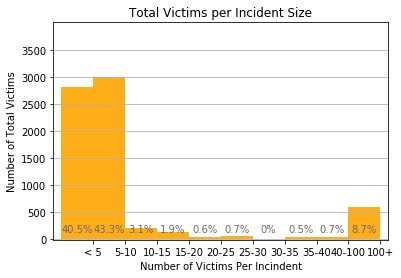

In [582]:
# Create list of colors based on being positive/negative
colors = []
# for item in numVictimsByGroup:
#     if 100 > item > 0:
#         colors.append('gainsboro')
#     elif 100 > item > 500:
#         colors.append('navajowhite')
#     elif 500 > item > 1000:
#         colors.append('orange')
#     elif 1000 > item > 3500:
#         colors.append('darkorange')

# Identify x-axis and y-axis, y min and ymax values from percent changes list
ymin = round(numVictimsByGroup.min(), -1)
ymax = int(numVictimsByGroup.max()/1000+1)*1000
x_axis = np.arange(1, len(numVictimsByGroup)+1, 1)
y_axis = np.arange(ymin, ymax, 500)
   
# Create bar chart
fig, ax = plt.subplots()
ChangeBar = ax.bar(x_axis, numVictimsByGroup, width = -1, align='edge', color = "orange", alpha=0.9, ecolor='black')

# Modify x-axis values and labels
ax.set_xlim(-0.25, len(numVictimsByGroup)+0.25)
ax.set_xticklabels(numVictimsByGroup.index)
ax.set_xticks(x_axis)
ax.set_xlabel("Number of Victims Per Incindent")

# Modify y-axis values and labels
ax.set_ylim(ymin - 10, ymax + 10)
ax.set_yticks(y_axis)
ax.set_ylabel("Number of Total Victims")

# Add grid and title
ax.set_title("Total Victims per Incident Size")
ax.grid(axis='y')

# Label percentages on chart based on x-value and centered on each bar with a y coordinate determined
# by positive/negative value
xpos = 'center'
ha = {'center': 'center', 'right': 'left', 'left': 'right'}
offset = {'center': 0.5, 'right': 0.57, 'left': 0.43}  # x_txt = x + w*off

for rect in ChangeBar:
    height = rect.get_height()
    height = int(height)
    perc = height/numVictimsByGroup.sum()*100
    perc = round(perc, 1)
    if perc > 0:
        ax.text(rect.get_x() + rect.get_width()*offset[xpos], 100,'{}'.format(perc)+'%', ha=ha[xpos], va='bottom', color = 'dimgray')
    elif perc == 0:
        ax.text(rect.get_x() + rect.get_width()*offset[xpos], 100,'{}'.format(0)+'%', ha=ha[xpos], va='bottom' , color = 'dimgray')

# Save graph
#plt.savefig("Images/Tumor_Change_Over_45_Day_Treatment")

# Show figure
plt.show()

In [158]:
incidentDenistyType_df

,Unnamed: 0,Incident Date,State,City/County,Address,# Killed,# Injured,Zipcode,Density Type,Density,Total Victims,Number of Victims
0,0,2014-12-29,LA,New Orleans,Poydras and Bolivar,0,4,70113,Metro,6907.57,4,< 5
1,1,2014-12-27,CA,Los Angeles,8800 block of South Figueroa Street,1,3,90003,Metro,18661.22,4,< 5
2,2,2014-12-27,CA,Sacramento,4000 block of May Street,0,4,95838,Metro,4053.81,4,< 5
3,3,2014-12-26,IL,East St. Louis,2500 block of Summit Avenue,1,3,62205,Suburban,1847.33,4,< 5
4,4,2014-12-24,MO,Saint Louis,18th and Pine,1,3,63103,Urban,3195.92,4,< 5
5,5,2014-12-23,KY,Winchester,260 Oxford Drive,1,3,40391,Metro,147.27,4,< 5
6,7,2014-12-22,NY,Webster,191 Lake Road,4,2,14580,Suburban,1187.60,6,5-10
7,8,2014-12-22,IL,Chicago,5700 block of South Green Street,0,5,60621,Metro,9633.05,5,5-10
8,9,2014-12-21,FL,Sarasota,4034 N Washington Blvd,2,2,34234,Metro,2980.12,4,< 5
9,10,2014-12-21,MS,Waynesboro,Central Avenue,1,4,39367,Rural,32.06,5,5-10


In [274]:
#incidentDenistyType_df["Density Type"] = incidentDenistyType_df["Density Type"]
#incidentDenistyType_df["Density Type"][0].apply(lambda x: x.strftime('%Y-%m'))
#pd.to_datetime(incidentDenistyType_df["Incident Date"][0], format='%Y00%m')
dataD = incidentDenistyType_df["Incident Date"][0:5]
dataD

test = [d.split("-") for d in dataD]
test
test = [t[0] for t in test]
test
dates = pd.to_datetime(test, format='%Y%m')
dates
#dates.apply(lambda x: x.strftime('%Y-%m'))

# weather_df["Date"] = pd.to_datetime(weather_df["Date"], unit='s')
# weather_df["Date"] = weather_df["Date"].apply(lambda x: x.date())
# weather_df.head()

[['2014', '12'],
 ['2014', '12'],
 ['2014', '12'],
 ['2014', '12'],
 ['2014', '12']]

In [328]:
season_df = incidentDenistyType_df[["Incident Date", "# Killed","# Injured","Density Type","Total Victims"]]
#incidentDenistyType_df["Incident Date"]
YrMo = [d.split("-") for d in season_df["Incident Date"]]
Yr = [t[0] for t in YrMo]
Mo = [t[1] for t in YrMo]
# YrMo
# for x in range(0, len(Yr)):
#     season_df.loc[x, "Year"] = Yr[x]
#     season_df.loc[x, "Month"] = Mo[x]
season_df["Year"] = Yr
season_df["Month"] = Mo
season_df.head()

C:\Users\lizma\Anaconda3\envs\PythonData\lib\site-packages\ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # Remove the CWD from sys.path while we load stuff.
C:\Users\lizma\Anaconda3\envs\PythonData\lib\site-packages\ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # This is added back by InteractiveShellApp.init_path()


,Incident Date,# Killed,# Injured,Density Type,Total Victims,Year,Month
0,2014-12-29,0,4,Metro,4,2014,12
1,2014-12-27,1,3,Metro,4,2014,12
2,2014-12-27,0,4,Metro,4,2014,12
3,2014-12-26,1,3,Suburban,4,2014,12
4,2014-12-24,1,3,Urban,4,2014,12


In [360]:
df14 = season_df[season_df["Year"] == "2014"]
df15 = season_df[season_df["Year"] == "2015"]
df16 = season_df[season_df["Year"] == "2016"]
df17 = season_df[season_df["Year"] == "2017"]

In [426]:
df14m = df14.groupby("Month")
df15m = df15.groupby("Month")
df16m = df16.groupby("Month")
df17m = df17.groupby("Month")
dfAvg = season_df.groupby("Month")
numberIncidents14 = df14m["Total Victims"].count()
totalVictims14 = df14m["Total Victims"].sum()
numberIncidents15 = df15m["Total Victims"].count()
numberIncidents16 = df16m["Total Victims"].count()
numberIncidents17 = df17m["Total Victims"].count()
numberIncidentsAvg = (numberIncidents14 + numberIncidents15 + numberIncidents16 + numberIncidents17)/4

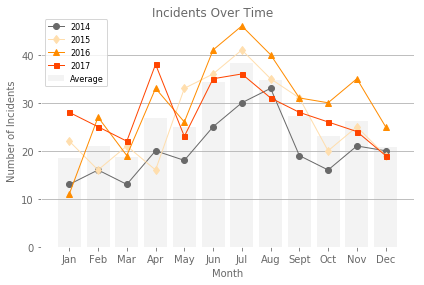

In [731]:
# Store x-axisand months in lists to use to plot graph
months = [m for m in np.arange(1, 13, 1)]
labels = ["Jan","Feb","Mar","Apr","May","Jun","Jul","Aug","Sept","Oct","Nov","Dec"]

# Define graph box and title
with plt.rc_context({'axes.edgecolor':'white', 'xtick.color':'dimgray', 'ytick.color':'dimgray'}):
    fig, ax = plt.subplots()
fig.suptitle("Incidents Over Time", fontsize=12, color ='dimgray' )

ax.bar(labels, numberIncidentsAvg, color = "lightgray", label = 'Average', alpha = .25)
ax.plot(labels, numberIncidents14, color = "dimgray", marker = 'o', linewidth = 1, label = '2014', )
ax.plot(labels, numberIncidents15, color = "navajowhite", marker = 'd', markersize='6', linewidth = 1, label = '2015')
ax.plot(labels, numberIncidents16, color = "darkorange", marker = '^',  markersize='6', linewidth = 1, label = '2016')
ax.plot(labels, numberIncidents17, color = "orangered", marker = 's', markersize='5', linewidth = 1, label = '2017')

# Set lables, legend, and grid
ax.grid(axis='y')
ax.legend(fontsize = 8)
ax.tick_params(colors='dimgray')
ax.set_ylabel("Number of Incidents", color ='dimgray' )
ax.set_xlabel("Month", color ='dimgray' , fontsize = 10)
plt.tight_layout()

# Save graph
#plt.savefig("Images/Survival_During_Treatment")

plt.savefig("Images/IncidenttsOverYear")

# Show figure
plt.show()

In [611]:
dfAvg = season_df.groupby("Month")
totFatal14 = df14m["# Killed"].sum()
totalVictims14 = df14m["# Killed"].sum()
totFatal15 = df15m["# Killed"].sum()
totFatal16 = df16m["# Killed"].sum()
totFatal17 = df17m["# Killed"].sum()

avgTotFatal14 = (totFatal14 + totFatal15 + totFatal16 + totFatal17)/4

In [612]:
avgTotFatal14

1.1486486486486487

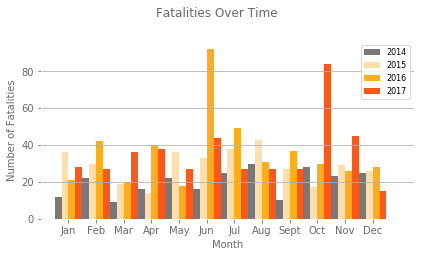

In [732]:
# Store months and x_axis in lists to use to plot graph
labels = ["Jan","Feb","Mar","Apr","May","Jun","Jul","Aug","Sept","Oct","Nov","Dec"]
monthsD = np.arange(0, len(labels), 1)
months = [float(m) for m in monthsD]

# Define graph box and title
with plt.rc_context({'axes.edgecolor':'white', 'xtick.color':'dimgray', 'ytick.color':'dimgray'}):
    fig, ax = plt.subplots()
fig.suptitle("Fatalities Over Time", fontsize=12, x = .51, y = .93, color ='dimgray' )

ax.set_xticks(months)

ax.set_xlim(-1, 12.5)

width = 0.25
#ax.bar([x for x in months], avgTotFatal14, align='edge', alpha=0.9, ecolor='black', color = 'whitesmoke', label = "2014")
ax.bar([(x-width) for x in months], totFatal14, -width, align='edge', alpha=0.9, ecolor='black', color = 'dimgray', label = "2014")
ax.bar([x for x in months], totFatal15, -width, align='edge', alpha=1, ecolor='black', color = 'navajowhite', label = "2015")
ax.bar([x for x in months], totFatal16, width, align='edge', alpha=0.9, ecolor='black', color = 'orange', label = "2016")
ax.bar([(x+width) for x in months], totFatal17, width, align='edge', alpha=0.9, ecolor='black', color = 'orangered', label = "2017")
#ax.plot(avgTotFatal14, linestyle=":")

# Set lables, legend, and grid
ax.grid(axis='y')
ax.legend(fontsize = 8)
ax.tick_params(colors='dimgray')
ax.set_aspect(1/15)
ax.set_xticklabels(labels)

ax.set_ylabel("Number of Fatalities", color ='dimgray' )
ax.set_xlabel("Month", color ='dimgray' , fontsize = 10)
plt.tight_layout()

# Save graph
#plt.savefig("Images/Survival_During_Treatment")
plt.savefig("Images/IncidentsOverYearBear")

# Show figure
plt.show()

In [618]:
zips = []
for x in incidentDenistyType_df["Zipcode"]:
    if x < 1000:
        #print("0" + x, int(x))
        x = "00" + str(x)
        zips.append(x)
        #print(df["Zipcode"][x])
    elif  1000 <= x < 10000:
        x = "0" + str(x)
        zips.append(x)
    else:
        x = str(x)
        zips.append(x)

incidentDenistyType_df["Zipcode"] = zips
incidentDenistyType_df.head()

,Unnamed: 0,Incident Date,State,City/County,Address,# Killed,# Injured,Zipcode,Density Type,Density,Total Victims,Number of Victims
0,0,2014-12-29,LA,New Orleans,Poydras and Bolivar,0,4,70113,Metro,6907.57,4,< 5
1,1,2014-12-27,CA,Los Angeles,8800 block of South Figueroa Street,1,3,90003,Metro,18661.22,4,< 5
2,2,2014-12-27,CA,Sacramento,4000 block of May Street,0,4,95838,Metro,4053.81,4,< 5
3,3,2014-12-26,IL,East St. Louis,2500 block of Summit Avenue,1,3,62205,Suburban,1847.33,4,< 5
4,4,2014-12-24,MO,Saint Louis,18th and Pine,1,3,63103,Urban,3195.92,4,< 5


In [619]:
lat = []
lon = []

for c in incidentDenistyType_df["Zipcode"]:

    try:
        data = zipcodes.matching(c)
        lat.append(data[0]['lat'])
        lon.append(data[0]['long'])
        
    except:
        print(f"{c} - Skipping...")
        
lat[0:15]

[30.06,
 33.96,
 38.64,
 38.61,
 38.63,
 37.99,
 43.21,
 41.83,
 27.33,
 31.67,
 41.61,
 42.27,
 40.66,
 40.24,
 25.77]

In [620]:
incidentDenistyType_df["Latitude"] = lat
incidentDenistyType_df["Longitude"] = lon
incidentDenistyType_df.head()

,Unnamed: 0,Incident Date,State,City/County,Address,# Killed,# Injured,Zipcode,Density Type,Density,Total Victims,Number of Victims,Latitude,Longitude
0,0,2014-12-29,LA,New Orleans,Poydras and Bolivar,0,4,70113,Metro,6907.57,4,< 5,30.06,-89.93
1,1,2014-12-27,CA,Los Angeles,8800 block of South Figueroa Street,1,3,90003,Metro,18661.22,4,< 5,33.96,-118.27
2,2,2014-12-27,CA,Sacramento,4000 block of May Street,0,4,95838,Metro,4053.81,4,< 5,38.64,-121.44
3,3,2014-12-26,IL,East St. Louis,2500 block of Summit Avenue,1,3,62205,Suburban,1847.33,4,< 5,38.61,-90.13
4,4,2014-12-24,MO,Saint Louis,18th and Pine,1,3,63103,Urban,3195.92,4,< 5,38.63,-90.24


In [644]:
gmaps.geojson_geometries.list_geometries()

dict_keys(['countries', 'countries-high-resolution', 'england-counties', 'us-states', 'us-counties', 'india-states', 'brazil-states'])

In [736]:
gmaps.configure(api_key=gkey)

fig = gmaps.figure(center=(36.5, -98.5795), map_type = 'SATELLITE', zoom_level=4)

# countries_geojson = gmaps.geojson_geometries.load_geometry('countries')
# states_geojson = gmaps.geojson_geometries.load_geometry('us-states')

heatmap_layer = gmaps.heatmap_layer(
    incidentDenistyType_df[["Latitude","Longitude"]], weights=incidentDenistyType_df["Total Victims"], dissipating = False,
    opacity = 1, max_intensity=250, point_radius=2
)

gini_layer1 = gmaps.geojson_layer(countries_geojson, fill_color=(217,217,217),fill_opacity=0,stroke_color=(153, 153, 153))
fig.add_layer(gini_layer1)
gini_layer = gmaps.geojson_layer(states_geojson, fill_color=(153, 153, 153),fill_opacity=.01, stroke_color=(153, 153, 153))
fig.add_layer(gini_layer)

# heatmap_layer.gradient = [
#     (191, 191, 191),
#     (255, 163, 102),
#     (255, 51, 0),
#     (230, 46, 0)
# ]


heatmap_layer.gradient = [
    (255, 255, 255),
    (255, 179, 128),
    (255, 133, 51),
    (255, 102, 0),
    (230, 57, 0)
]


fig.add_layer(heatmap_layer)

fig


Figure(layout=FigureLayout(height='420px'))